
French Road Accidents
==============
## __Machine learning models for multiclass classification__

**Authors**:
> - Pablo Galán de Anta
> - Jennifer Pohlsen
> - Ilinca Suciu

**Project supervisor**: Lucas Varela - DataScientest

**Date**: 2023-12-08

## __Modules loading__

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.metrics import classification_report_imbalanced
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from tqdm import tqdm
import time
from prince import MCA
from joblib import Parallel, delayed
from scipy.stats import chi2_contingency
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids

## __Pre-processing__

We just focus on years 2019-2022 so we open those datasets

In [2]:
df1 = pd.read_csv('../data/accidents_2019.csv')
df2 = pd.read_csv('../data/accidents_2020.csv')
df3 = pd.read_csv('../data/accidents_2021.csv')
df4 = pd.read_csv('../data/accidents_2022.csv')

df = pd.concat([df1,df2,df3,df4])
df.drop('Unnamed: 0', axis=1, inplace=True)

# Deleting these variables to save RAM
del df1; del df2; del df3; del df4

df.head()

,Num_Acc,place,catu,severity,gender,trajet,secu,locp,actp,comp,...,int,atm,col,com,adr,gps,lat,long,dep,age
0,201900000001,2.0,2.0,1.0,2.0,0.0,NaN,-1.0,-1,-1.0,...,1,1,2,93053,AUTOROUTE A3,NaN,48.896210,2.470120,93,17.0
1,201900000001,1.0,1.0,1.0,2.0,5.0,NaN,-1.0,-1,-1.0,...,1,1,2,93053,AUTOROUTE A3,NaN,48.896210,2.470120,93,26.0
2,201900000001,1.0,1.0,0.0,1.0,0.0,NaN,-1.0,-1,-1.0,...,1,1,2,93053,AUTOROUTE A3,NaN,48.896210,2.470120,93,60.0
3,201900000002,1.0,1.0,1.0,2.0,0.0,NaN,-1.0,-1,-1.0,...,1,1,6,93066,AUTOROUTE A1,NaN,48.930700,2.368800,93,25.0
4,201900000003,1.0,1.0,0.0,1.0,0.0,NaN,-1.0,0,-1.0,...,1,1,4,92036,AUTOROUTE A86,NaN,48.935872,2.319174,92,23.0


In [3]:
# Droping some columns
cols_to_drop = ['nbv', 'larrout', 'voie', 'adr']
df.drop(columns=cols_to_drop, axis=1, inplace=True)

In [4]:
length = len(df)
thres  = 0.9 # Threshold above which we delete columns
cols   = df.columns.values # Getting the columns
idx    = df.isna().sum().values/length < thres # Deleting conditions
idx[0] = True # Keep the unique identifier column 'Num_Acc'
df_cleaned = df[cols[idx]] # Purging all columns with % nulls above 90%

In [5]:
# Converting 'actp' 'A' and 'B' categories into numbers
df_cleaned.loc[df_cleaned['actp'] == 'A', 'actp'] = '10'
df_cleaned.loc[df_cleaned['actp'] == 'B', 'actp'] = '11'
df_cleaned['actp'] = df_cleaned['actp'].astype('int64')

# Discarding the 0 in 'gender' column
df_cleaned = df_cleaned[df_cleaned['gender'] != 0]

/tmp/ipykernel_34156/1375660685.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['actp'] = df_cleaned['actp'].astype('int64')


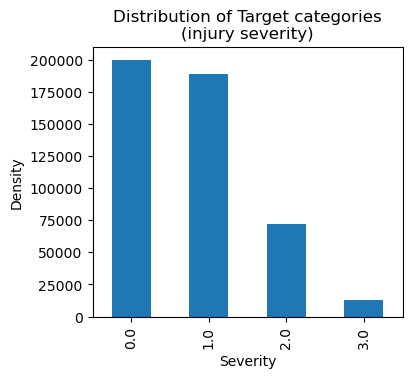

In [6]:
plt.figure(figsize = [4,3.5])
df_cleaned['severity'].value_counts().plot(kind = 'bar')
plt.xlabel('Severity')
plt.ylabel('Density')
plt.title('Distribution of Target categories\n(injury severity)')
plt.show()

So there are imbalance in categories 2 (`Hospitalized injury`) and 3 (`Killed`). We need to apply a random oversampler to account for the imbalance.

First let's clean some variables using the variance selector

In [7]:
# Set the threshold for variance
threshold = 0.01

# Extract numerical columns from merge_cleaned (assuming merge_cleaned is a DataFrame containing numeric columns)
numeric_columns = df_cleaned.select_dtypes(include=['number'])

# Initialize VarianceThreshold selector
selector = VarianceThreshold(threshold=threshold)

# Fit and transform the data using the selector
selected_features = selector.fit_transform(numeric_columns)

# Get the columns that are selected
selected_columns = numeric_columns.columns[selector.get_support()]

# Create a new DataFrame with selected features
df_cleaned = pd.DataFrame(data=selected_features, columns=selected_columns)

# Transform into str the Num_Acc column
df_cleaned['Num_Acc'] = df_cleaned['Num_Acc'].astype('int64').astype('str')

In [8]:
# Preparing the features matrix by deleting more features
cols_to_drop = ['lat', 'long']
df_cleaned.drop(columns=cols_to_drop, axis=1, inplace=True)

In [9]:
# Converting object type columns into integers
cols = ['place', 'catu', 'severity', 'gender', 'trajet', 'locp', 'comp', 'age', 'secu1',
        'secu2', 'secu3', 'catr', 'circ', 'vosp', 'surf', 'infra', 'situ', 'vma', 'actp',
       'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor', 'v1', 'prof', 'plan', 'month',
       'day', 'lum', 'agg', 'atm', 'col', 'int']
for ii in cols:
    df_cleaned[ii] = df_cleaned[ii].astype('int64')

In [10]:
df_cleaned.dtypes # Check the types of the variables

Num_Acc      object
place         int64
catu          int64
severity      int64
gender        int64
trajet        int64
locp          int64
actp          int64
comp          int64
secu1         int64
secu2         int64
secu3         int64
senc          int64
catv          int64
obs           int64
obsm          int64
choc          int64
manv          int64
motor         int64
catr          int64
v1            int64
circ          int64
vosp          int64
prof          int64
plan          int64
surf          int64
infra         int64
situ          int64
vma           int64
year        float64
month         int64
day           int64
lum           int64
agg           int64
int           int64
atm           int64
col           int64
age           int64
dtype: object

In [11]:
# Deleting category -1 in 'gender'
df_cleaned = df_cleaned[df_cleaned['gender'] != -1]

# Check how many variables present just two categories
two_categories = df_cleaned.columns[df_cleaned.nunique() == 2]

# Displaying columns with just two categories for encoding
print("Columns with just two categories:")
print(two_categories)

Columns with just two categories:
Index(['gender', 'agg'], dtype='object')


In [12]:
# Encoding gender and agg
df_cleaned['gender'][df_cleaned['gender'] == 2] = 0
df_cleaned['agg'][df_cleaned['agg'] == 2] = 0

# Unique years in your dataset
#unique_years = df_cleaned['year'].unique()

# Choose a specific year as the cutoff for splitting
#split_year = 2020

# Storing the year column into a year variable
#year = df_cleaned['year']
#df_cleaned.drop('year', axis=1, inplace=True)

#### Pre-processing secu1, 2, 3 variables

In [13]:
new_secu  = df_cleaned#[['Num_Acc', 'secu1', 'secu2', 'secu3']]
new_secu[['secu1', 'secu2', 'secu3']] = new_secu[['secu1', 'secu2', 'secu3']].astype('str')
new_secu = pd.get_dummies(new_secu, columns=['secu1', 'secu2', 'secu3'])
new_secu = new_secu.drop(['secu1_-1', 'secu1_0', 'secu2_0', 'secu3_0', 'secu2_-1', 'secu3_-1'], axis =1) # discard unnecessary dummies
for suffix in ['1', '2', '3', '4', '5', '6', '7', '8', '9']:
        var_name1 = 'secu1_' + suffix
        var_name2 = 'secu2_' + suffix
        var_name3 = 'secu3_' + suffix
       # print(var_name1, '; ', var_name2, '; ', var_name3)
        new_secu['secu_' + suffix] = new_secu[var_name1] + new_secu[var_name2] + new_secu[var_name3] # create new unique variable for the category
        new_secu = new_secu.drop([var_name1, var_name2, var_name3], axis = 1) # drop old variables of that category

# Check new security variables
#new_secu.head()


# 4. Optional rename columns ... according to the type of security they're coding for
col_mapping = {
    'secu1_-2' : 'secu_absent',
    'secu1_-3': 'secu_NA',
    'secu_1': 'secu_belt',
    'secu_2': 'secu_helmet',
    'secu_3': 'secu_child-restraint',
    'secu_4': 'secu_reflective-vest',
    'secu_5': 'secu_airbag',
    'secu_6': 'secu_gants',
    'secu_7': 'secu_airbag-gants',
    'secu_8': 'secu_undet',
    # secu_undet = undeterminable, probably in severe accidents;
    # in which case I suggest removing it (because it depend on accident severity, and not the other way around)
    'secu_9': 'secu_other'
}

new_secu = new_secu.rename(columns = col_mapping)

cols = ['secu_absent', 'secu_NA', 'secu_belt', 'secu_helmet', 'secu_child-restraint', 'secu_reflective-vest',
       'secu_airbag', 'secu_gants', 'secu_airbag-gants', 'secu_undet']

# 5. Replace values of '2' and '3' with '1'
new_secu.info()
new_secu[cols] = new_secu[cols].replace({2.0: 1,
                             3.0 : 1})

# Check that there are no additional otliers present (i.e. values consist exclusively of '0' and '1')
new_secu.describe()

# NOTE: the new_secu dataframe needs to be now merged with the dataframe it originated from, where secu_1, secu_2 and secu_3 variables will be dropped.
#df_cleaned = df_cleaned.drop(['secu1', 'secu2', 'secu3'], axis = 1)
# merge_02['Num_Acc'] = merge_02['Num_Acc'].astype(object)
#df_cleaned = df_cleaned.merge(new_secu, left_on=['Num_Acc'], right_on=['Num_Acc'])
df_cleaned = new_secu
del new_secu

df_cleaned.drop('Num_Acc', axis=1, inplace=True)

# 6. Check correlations between the newly constructed security variables

#secu_and_sev = list(merge_cleaned.loc[:,'secu_absent':'secu_other'].columns)
#secu_and_sev.append('severity')
#print(secu_and_sev)

#plt.figure(figsize = (10,8))
#sns.heatmap(merge_cleaned.loc[merge_cleaned['year'].isin([2019, 2020, 2021, 2022]), 
#                              merge_cleaned.columns.isin(secu_and_sev)].corr(), 
#            cmap = 'bwr', center = 0, annot = True, fmt = ".2f");
#del secu_and_sev

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473519 entries, 0 to 473522
Data columns (total 46 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Num_Acc               473519 non-null  object 
 1   place                 473519 non-null  int64  
 2   catu                  473519 non-null  int64  
 3   severity              473519 non-null  int64  
 4   gender                473519 non-null  int64  
 5   trajet                473519 non-null  int64  
 6   locp                  473519 non-null  int64  
 7   actp                  473519 non-null  int64  
 8   comp                  473519 non-null  int64  
 9   senc                  473519 non-null  int64  
 10  catv                  473519 non-null  int64  
 11  obs                   473519 non-null  int64  
 12  obsm                  473519 non-null  int64  
 13  choc                  473519 non-null  int64  
 14  manv                  473519 non-null  int64  
 15  

#### Dummyfication of the variables

In [14]:
# List of columns to convert into dummy without gender and agg
cols_to_dummy = df_cleaned.columns.difference(['gender', 'agg', 'age', 'severity', 'birth_year', 'year', 'secu_absent',
                                              'secu_NA', 'secu_belt', 'secu_helmet', 'secu_child-restraint', 'secu_reflective-vest',
                                              'secu_airbag', 'secu_gants', 'secu_airbag-gants', 'secu_undet', 'secu_other'])

# Convert the columns into variable dummies
df_cleaned = pd.get_dummies(df_cleaned, columns=cols_to_dummy)

#### Spliting in training and testing sets: rescaling of quantitative variables

In [15]:
X = df_cleaned.drop('severity', axis=1) # Features
y = df_cleaned['severity'] # Target

# Split the data based on the 'year' column to account for the dependence with time
#X_train = X[year < split_year]
#y_train = y[year < split_year]
#X_test = X[year >= split_year]
#y_test = y[year >= split_year]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

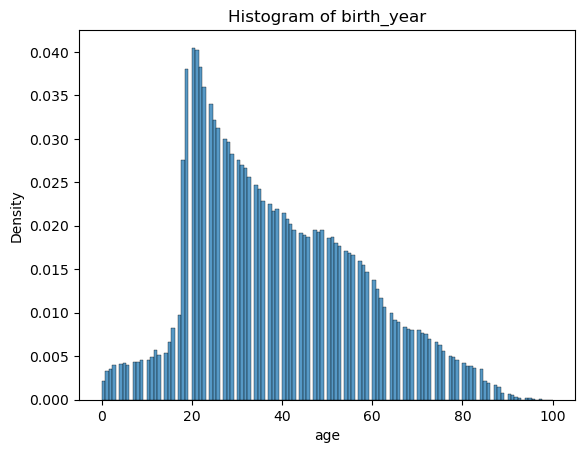

In [16]:
# Before scaling the variables, let's take a look at their distributions
# Histogram of the variable birth_age
sns.histplot(X_train["age"], stat="density")
plt.title("Histogram of birth_year")
plt.show();

# Histogram of the variable year
#sns.histplot(X_train["year"], stat="density")
#plt.title("Histogram of year")
#plt.show()

# None of the two variables follow a normal distribution, so it is not recomended to apply
# a standard normalisation but a min-max scaler between 0 and 1

In [17]:
# Extract the 'birth_year' and 'year' columns from X_train and X_test
columns_to_scale = ['age', 'year']

# Normalization between 0 and 1 
scaler = MinMaxScaler()
# Fit the scaler on the specified columns in X_train
scaler.fit(X_train[columns_to_scale])

# Create the StandardScaler object
#scaler = StandardScaler()

# Fit the scaler on the specified columns in X_train
#scaler.fit(X_train[columns_to_scale])

# Transform the specified columns in both X_train and X_test
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale]  = scaler.transform(X_test[columns_to_scale])

#### __Applying SMOTE OverSampling on the training set__

In [18]:
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)
print('Number of oversampled elements for each class (SMOTE):', dict(pd.Series(y_sm).value_counts()))

Number of oversampled elements for each class (SMOTE): {1: 159731, 0: 159731, 2: 159731, 3: 159731}


## __Models training__

Let's try to train RandomClassifier, LogisticRegression, XGboost and ANN on the SMOTE training set.

### __RandomForest Classifier on the training set__

In [68]:
rf = RandomForestClassifier(n_estimators = 500,
                            criterion = "entropy",
                            max_depth = None,
                            min_samples_split = 10,
                            min_samples_leaf = 1,
                            n_jobs = 6)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Cross tab
cross_tab = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Calculate accuracy score on the test data
class_report = classification_report_imbalanced(y_test, y_pred)

# Print the confusion matrix (cross_tab) and the accuracy score
print('=========================')
print("Cross-tab:\n",cross_tab)
print('\n=========================')
print('Classification report:\n',class_report)

Cross-tab:
 Predicted      0      1     2   3
Actual                           
0          33599   5476   903   3
1          10971  23971  2724  11
2           2487   6133  5817  35
3            384    726  1393  71

Classification report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.71      0.84      0.75      0.77      0.79      0.63     39981
          1       0.66      0.64      0.78      0.65      0.71      0.49     37677
          2       0.54      0.40      0.94      0.46      0.61      0.36     14472
          3       0.59      0.03      1.00      0.05      0.17      0.02      2574

avg / total       0.66      0.67      0.80      0.65      0.71      0.52     94704



So the performance is really bad for categories 2 and 3. We can compare with the oversampled training set `X_sm` and `y_sm`.

### __RandomForest Classifier on the SMOTE training set__

In [69]:
rf = RandomForestClassifier(n_estimators = 500,
                            criterion = "entropy",
                            max_depth = None,
                            min_samples_split = 10,
                            min_samples_leaf = 1,
                            n_jobs = 6)
rf.fit(X_sm, y_sm)

# Predictions
y_pred = rf.predict(X_test)

# Cross tab
cross_tab = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Calculate accuracy score on the test data
class_report = classification_report_imbalanced(y_test, y_pred)

# Print the confusion matrix (cross_tab) and the accuracy score
print('=========================')
print("Cross-tab:\n",cross_tab)
print('\n=========================')
print('Classification report:\n',class_report)

Cross-tab:
 Predicted      0      1     2    3
Actual                            
0          33185   5016  1708   72
1          10644  22471  4428  134
2           2181   4712  7215  364
3            300    510  1420  344

Classification report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.72      0.83      0.76      0.77      0.79      0.64     39981
          1       0.69      0.60      0.82      0.64      0.70      0.48     37677
          2       0.49      0.50      0.91      0.49      0.67      0.43     14472
          3       0.38      0.13      0.99      0.20      0.36      0.12      2574

avg / total       0.66      0.67      0.81      0.66      0.73      0.53     94704



### __XGboost__

In [19]:
import xgboost as xgb 

# Convert the data into DMatrix format (optimized data structure for XGBoost)
dtrain = xgb.DMatrix(X_sm, label=y_sm)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'n_estimators': 1000, # Number of estimators
    'num_class': 4,  # Number of classes (categories)
    'eval_metric': 'merror',  # Metric to evaluate on (multiclass classification error rate)
    'learning_rate': 0.001, # Learning rate
    'max_depth': 3,  # Maximum depth of a tree
    'eta': 0.1,  # Learning rate
    'subsample': 1.0,  # Fraction of samples used for training each tree
    'colsample_bytree': 0.8,  # Fraction of features used for training each tree
    'seed': 42  # Random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Cross tab
cross_tab = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Calculate accuracy score on the test data
class_report = classification_report_imbalanced(y_test, y_pred)

# Print the confusion matrix (cross_tab) and the accuracy score
print('=========================')
print("Cross-tab:\n",cross_tab)
print('\n=========================')
print('Classification report:\n',class_report)

/home/pablo/anaconda3/envs/ml_env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:01:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-tab:
 Predicted    0.0    1.0   2.0   3.0
Actual                             
0          30862   5723   840  2556
1          13781  14637  4959  4300
2           3379   2878  3332  4883
3            542    316   448  1268

Classification report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.64      0.77      0.68      0.70      0.72      0.53     39981
          1       0.62      0.39      0.84      0.48      0.57      0.31     37677
          2       0.35      0.23      0.92      0.28      0.46      0.20     14472
          3       0.10      0.49      0.87      0.16      0.66      0.41      2574

avg / total       0.57      0.53      0.79      0.53      0.62      0.39     94704



### __Artificial Neural Network__

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 32)                11552     
                                                                 
 layer_1 (Dense)             (None, 64)                2112      
                                                                 
 layer_2 (Dense)             (None, 128)               8320      
                                                                 
 layer_3 (Dense)             (None, 128)               16512     
                                                                 
 output (Dense)              (None, 4)                 516       
                                                                 
Total params: 39012 (152.39 KB)
Trainable params: 39012 (152.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50


2023-11-22 12:10:59.125225: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1472080320 exceeds 10% of free system memory.


15974/15974 [==============================] - 16s 950us/step - loss: 0.7556 - recall_2: 0.6068 - val_loss: 1.6851 - val_recall_2: 0.1792
Epoch 2/50
15974/15974 [==============================] - 15s 912us/step - loss: 0.7194 - recall_2: 0.6279 - val_loss: 1.4388 - val_recall_2: 0.2094
Epoch 3/50
15974/15974 [==============================] - 15s 919us/step - loss: 0.7095 - recall_2: 0.6344 - val_loss: 1.1052 - val_recall_2: 0.3860
Epoch 4/50
15974/15974 [==============================] - 15s 935us/step - loss: 0.7033 - recall_2: 0.6369 - val_loss: 1.1336 - val_recall_2: 0.3528
Epoch 5/50
15974/15974 [==============================] - 15s 950us/step - loss: 0.6994 - recall_2: 0.6398 - val_loss: 1.1211 - val_recall_2: 0.3879
Epoch 6/50
15974/15974 [==============================] - 15s 935us/step - loss: 0.6964 - recall_2: 0.6419 - val_loss: 1.0263 - val_recall_2: 0.4148
Epoch 7/50
15974/15974 [==============================] - 14s 850us/step - loss: 0.6936 - recall_2: 0.6431 - val_loss

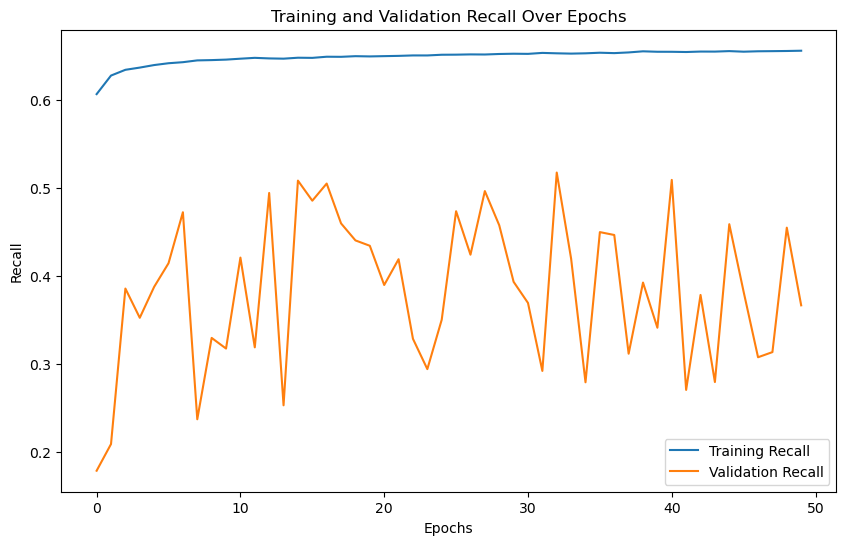

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.metrics import Recall # We are interested into measure the Recall of the DNN output
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Convert the target variable to categorical format
y_sm_categorical   = to_categorical(y_sm, num_classes=4)
y_test_categorical = to_categorical(y_test, num_classes=4)

# Define the neural network architecture
model = Sequential()
model.add(Dense(32, input_dim=X_sm.shape[1], activation='relu', name='input'))
model.add(Dense(64, activation='relu', name='layer_1'))
model.add(Dense(128, activation='relu', name='layer_2'))
model.add(Dense(128, activation='relu', name='layer_3'))
model.add(Dense(4, activation='softmax', name='output'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = [Recall()])

print(model.summary())

# Train the neural network
history = model.fit(X_sm, y_sm_categorical, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert predictions to categorical format for classification report
y_test_categorical = np.argmax(y_test_categorical, axis=1)

# Cross tab
cross_tab = pd.crosstab(y_test_categorical, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Display classification report
class_names = ['Category 0', 'Category 1', 'Category 2', 'Category 3']
class_report = classification_report(y_test_categorical, y_pred, target_names=class_names)

# Print the confusion matrix (cross_tab) and the accuracy score
print('=========================')
print("Cross-tab:\n",cross_tab)
print('\n=========================')
print('Classification report:\n',class_report)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['recall_2'], label='Training Recall')
plt.plot(history.history['val_recall_2'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training and Validation Recall Over Epochs')
plt.legend()
plt.show()